In [2]:
%load_ext Cython

In [38]:
%%cython -a
cdef extern from "math.h":
    float INFINITY
cdef double INF = INFINITY

ctypedef unsigned long long int64


cdef int64 test[2][2]

print 2 < 1.02 * INF

True


In [11]:
%%cython -a
#cython: cdivision = True,profile = False

cimport cython
import sys
cimport tictactics_cython
from tictactics_cython cimport Board
import numpy as np
import itertools
import matplotlib
import cProfile
from IPython import display
from matplotlib import pyplot as plt
import random
game = Board()

ctypedef unsigned long long int64
cdef extern from "math.h":
    float INFINITY

# cache = []

cdef enum:
#     PRIME = 33333331
    PRIME = 15000017
#     PRIME = 4999999
#     PRIME = 1000003
#     PRIME = 555557
    NODE_SIZE = 6
    MAX_MOVES = 81
    MAX_OUTCOMES = 3
#     PRIME = 49999
#     PRIME = 51


cdef int log_len
cdef double INF = INFINITY
cdef int64 INTINF = -1
cdef int64 KEY_INIT = -1

cdef int64 cache[2*PRIME+2][NODE_SIZE]
# cache = [[0]*6 for _ in xrange(2*PRIME)]

# def change_cache10(unsigned long long num):
#     cache[1][0] = num
# def print_cache10():
#     print cache[1][0]
cdef long long FORGOTTEN,STORED,NODES_VISITED
# cdef object game.actions()

def init():
    global FORGOTTEN,STORED,NODES_VISITED
    cdef int i,j
    for i in xrange(2*PRIME+2):
        cache[i][0] = KEY_INIT
        for j in xrange(1,NODE_SIZE):
            cache[i][j] = 0
    FORGOTTEN=0
    STORED=0
    NODES_VISITED=0
            
init()
def get_cache(int node_size , int64 key = 0):
    if key == 0:
        return cache[2*PRIME+1]
    cdef int64 node[NODE_SIZE]
    cache_pull(key,node,node_size)
    return node



#the cache should save infomation on all of the children  (maybe?) the lock will still be huge
#keeping child info saves on going up and down the tree to find child information
#it should also remember how many nodes were searched to get these values
        
def default_callback(game,role,root_key,children,grandchildren,n_outcomes,clear = True):
    
    if clear:
        display.clear_output(wait = True)
    print 'nodes visited  ',NODES_VISITED
    print 'cache space    ',2*PRIME
    print 'nodes stored   ', STORED
    print 'nodes forgotten', FORGOTTEN
    print 'current depth  ',len(game.log)-log_len
    print 'current node   ',' '.join(map(lambda x: ''.join(map(str,x)),game.log[log_len:log_len+30]))
    
    #cdef int64 node[NODE_SIZE]
    #cache_pull(game.key,node)
    #print node
    
    print_dfpn(game,role,root_key,children,grandchildren,n_outcomes)
    sys.stdout.flush()
    
def print_dfpn(game,role,root_key,children,grandchildren,n_outcomes):
    cdef int node_size
    cdef int64 node[NODE_SIZE]
    cdef int64 info_n[NODE_SIZE]
    node_size = 2*n_outcomes 
    info_n = cache[2*PRIME+1]
    info = ['   INF' if info_n[i] == -1 else info_n[i] for i in xrange(2*n_outcomes)]
    

    print 'role: '+ role
    print '  root: work: {:9} '.format(info[1]) + ''.join(['pn{:1}: {:6} '.format(i,info[2+i]) for i in xrange(n_outcomes-1)]
                                  ) + ''.join(['dn{:1}: {:6} '.format(i,info[1+i+n_outcomes]) for i in xrange(n_outcomes-1)])
    print
    print 'role: '+ ('max' if role=='min' else 'min')
    
                                              
    
    for move in children:
        key = children[move]
        cache_pull(key,node,node_size)
        if node[0] == KEY_INIT:
            print_node = ['????']*(2*n_outcomes)
        else:
            print_node =   ['   INF' if node[i] == -1 else node[i] for i in xrange(2*n_outcomes)]
        
        print '{:6}: work: {:9} '.format(move,print_node[1]
            ) + ''.join(['pn{:1}: {:6} '.format(i,print_node[2+i]) for i in xrange(n_outcomes-1)]
            ) + ''.join(['dn{:1}: {:6} '.format(i,print_node[1+i+n_outcomes]) for i in xrange(n_outcomes-1)])        
                                              
    print

    if len(game.log) > log_len:
        move = game.log[log_len]
        print 'expanding move ' + str(move)
        print 'role: ' + role

        for move2 in grandchildren[move]:
            key = grandchildren[move][move2]
            cache_pull(key,node,node_size)
            if node[0] == KEY_INIT:
                print_node = ['????']*(2*n_outcomes)
            else:
                print_node =   ['   INF' if node[i] == -1 else node[i] for i in xrange(2*n_outcomes)]
            print '{:6}: work: {:9} '.format(move2,print_node[1]
                ) + ''.join(['pn{:1}: {:6} '.format(i,print_node[2+i]) for i in xrange(n_outcomes-1)]
                ) + ''.join(['dn{:1}: {:6} '.format(i,print_node[1+i+n_outcomes]) for i in xrange(n_outcomes-1)])   
        print
    
cpdef print_tree(Board game,int result,int n_outcomes = 3 , int current_depth=0,int max_depth = 3):
    if current_depth>max_depth:
        return ''
    s=''
    if game.result == result:
        return 'p1win' if result == 1 else 'p2win'
    
    cdef int64 node[NODE_SIZE]
    cdef int64 child[NODE_SIZE]
    cdef int64 key
    cdef int role
    cdef int node_size = n_outcomes*2
    key = game.key
    cache_pull(game.key,node,node_size)
    if node[0] == KEY_INIT:
        return '??'
    
    if game.title == 'tic tactics':
        role = 1 if game.player == 0 else -1 #tictactics
    else:
        role = 1 if game.player == 1 else -1 #connect four, tictactoe, mnk
        
    if result * role == 1: #refutation

        for move in game.legal_moves():
            game.update_move(move)
            if game.result == result:
                break
            cache_pull(game.key,child,node_size)
            
            if child[0] == KEY_INIT:
                game.erase_move()
                continue
            if result ==1 and child[2]==0 or result == -1 and child[node_size - 1] == 0:
                break
            game.erase_move()
        if game.key == key: #if no move worked
            s += "??"
            
        else:
            s += str(move)
            if current_depth<max_depth:
                if game.over:
                    if game.result == 1:
                        s+= ' p1win'
                    elif game.result == -1:
                        s+= ' p2win'
                    else:
                        s+= ' draw'
                else:
                    s += print_tree(game,result,current_depth = current_depth+1,max_depth=max_depth)
            game.erase_move()

    else:#branch
        for move in game.legal_moves():
            s += '\n' + '\t'*(current_depth)
            s += str(move)
            game.update_move(move)
            if game.over:
                if game.result == 1:
                    s+= ' p1win'
                elif game.result == -1:
                    s+= ' p2win'
                else:
                    s+= ' draw'
            else:
                s += print_tree(game,result,n_outcomes = 3,current_depth = current_depth,max_depth=max_depth)
            game.erase_move()
    return s

cdef inline void get_2_smallest(int64* array,int size,int* f,int* s):
    cdef:
        int64 first
        int64 second
        int i
    f[0] = size
    s[0] = size+1
    first = -1
    second = -1
    for i in xrange(size):
        if array[i]<=first:
            second = first
            first  = array[i]
            s[0]=f[0]
            f[0]=i
        elif array[i]<=second:
            second = array[i]
            s[0]=i
    
'''
node will have format [key,work,GW,GT,ST,SL]
'''
cdef void cache_push(int64 key,int64* node,int node_size):
    global FORGOTTEN
    global STORED
    
    cdef:
        long index
        int64 lock,biglock,newlock,swap_dummy
        int i
        
    index = key%PRIME
    lock = key
    biglock = cache[2*index][0]
    newlock = cache[2*index+1][0]

    if biglock == lock:
        for i in xrange(node_size):
            cache[2*index][i] = node[i]
    else:
        if biglock == KEY_INIT:
            STORED += 1
            for i in xrange(node_size):
                cache[2*index][i] = node[i]
        else:
        
            if newlock == lock:
                None
            elif newlock == KEY_INIT:
                STORED += 1
            else:
                FORGOTTEN += 1

            for i in xrange(node_size):
                cache[2*index+1][i] = node[i]
        
    if cache[2*index+1][1] > cache[2*index][1]:
        
        for i in xrange(node_size):
            swap_dummy = cache[2*index][i]
            cache[2*index][i] = cache[2*index+1][i]
            cache[2*index+1][i] = swap_dummy
#####@cython.profile(False)
cdef void cache_pull(int64 key,int64* node,int node_size):
    cdef:
        int64 lock,biglock,newlock
        long index
        int i
        
    index = key%PRIME
    lock = key
    biglock = cache[2*index][0]
    newlock = cache[2*index+1][0]
    node[0] = KEY_INIT
    for i in xrange(1,node_size):
        node[i] = 0

    if biglock == lock:
        for i in xrange(node_size):
            node[i] = cache[2*index][i]
            
        
    if newlock == lock:
        for i in xrange(node_size):
            node[i] = cache[2*index+1][i]

cdef void dfpn_expand(int64* node,int64 key , int game_over , int game_result , int n_splits):
    cdef int i
    
    node[0] = key
    node[1] = 1
        
    if game_over:
        
        for i in xrange(n_splits):
            if game_result <= i:
                node[i+2] = 0
                node[i+2+n_splits] = -1
            else:
                node[i+2] = -1
                node[i+2+n_splits] = 0
    else:
        for i in xrange(n_splits):
            node[i+2] = 1
            node[i+2+n_splits] = 1     
                
DEBUG = [0]*100  
DEBUG_INDEX = 0L

def solve(Board game,int n_outcomes,dict result_to_outcome,object start,
          new_callback=None, long callback_freq = 100000,double epsilon = 1.25,int root = 0):
    '''
    A python wrapper used to set up the callback function and call the c-function search
    '''
    global callback
    global log_len
    cdef int64 node[NODE_SIZE]
    cdef int64 root_key
    cdef object children,grandchildren
    cdef int result
    cdef int upper,lower
    upper = n_outcomes-1
    lower = -1
    log_len = len(game.log)
    children = {}
    grandchildren = {}
    if game.title == 'tic tactics':
        role = 'max' if game.player == 0 else 'min'
    else:
        role = 'max' if game.player == 1 else 'min'
        
    if new_callback is None:
        root_key = game.key
        for move in game.legal_moves():
            game.update_move(move)
            children[move] = game.key
            grandchildren[move] = {}
            for move2 in game.legal_moves():
                game.update_move(move2)
                grandchildren[move][move2] = game.key
                game.erase_move()
            game.erase_move()
        def callback(game):
            default_callback(game,role,root_key,children,grandchildren,n_outcomes,clear = True)
        
        
    else:
        callback = new_callback
        
    while start > lower and start < upper:
        
        dfpn_search(game,node,start,-1,-1,epsilon,root,callback_freq,n_outcomes - 1,result_to_outcome)
        if node[2+start] == 0:
            upper = start
            start -= 1
        else:
            lower = start
            start += 1    
    
    callback(game)
    while len(game.log)>log_len:
        game.erase_move()
    result = 0
    if cache[2*PRIME+1][2]==0:
        result = 1
    elif cache[2*PRIME+1][2* n_outcomes - 1]==0:
        result = -1
    tree = print_tree(game,result,3,0,4)
    return node,tree

cdef dfpn_search(Board game,int64* node,int o, int64 pnt,int64 dnt, double epsilon = 1.25,int root = 0,long callback_freq = 0,
                 int n_splits = 1,dict result_to_outcome =  {1:0,-1:1}):
    cdef:
        int64 key,work
        int role,i,j,solved,na,pni,dni,node_size
        double ep = epsilon
        int64 pn[MAX_OUTCOMES]
        int64 dn[MAX_OUTCOMES]
        
    node_size = 2*n_splits + 2
    pni = 2+o
    dni = 2+o+n_splits    
    
    global NODES_VISITED
    NODES_VISITED +=1

    if callback_freq:        
        if NODES_VISITED % callback_freq==0:
            callback(game) #global callback set by dfpn_run

    #init values for proof numbers of this node
    key = game.key
    cache_pull(key,node,node_size)
    if node[0] == KEY_INIT:
        dfpn_expand(node,key,game.over,result_to_outcome[game.result],n_splits) #returns node
    key2 = node[0]
    work = node[1]
    for j in xrange(n_splits):
        pn[j]   = node[2 + j]
        dn[j]   = node[2 + j + n_splits]
    

    global DEBUG_INDEX
#     DEBUG[DEBUG_INDEX%100] = {'where':'outside','threshholds':(pnt,dnt) , 'pn' : (pn[0],pn[1],dn[0],dn[1])}
#     DEBUG_INDEX +=1

    if game.title == 'tic tactics':#this should be standardized
        role = 1 if game.player == 0 else -1 #tictactics
    else:
        role = 1 if game.player == 1 else -1 #connect four, tictactoe, mnk
    
    if root:#init the root for callback purposes


        for i in xrange(node_size):
            cache[2*PRIME+1][i] = node[i]
        
    solved = 0
    if pn[o]==0 or dn[o]==0:
        solved = 1
    if solved:
        cache_push(key,node,node_size)
        return
    
    if pn[o] > pnt or dn[o] > dnt or solved:
        return 

    #initialize
    #slow python stuff
    actions = game.legal_moves()
    na = len(actions)

    cdef:
        int64 pnc[MAX_OUTCOMES][MAX_MOVES]
        int64 dnc[MAX_OUTCOMES][MAX_MOVES]
        int64 solvedc[MAX_MOVES]
        int64 workc[MAX_MOVES]
        
        int64 child[NODE_SIZE]
        int64 child_pn,child_dn
        int64 child_pnt,child_dnt
        int64 other_pn,other_dn
        int f_index,s_index
        
    for i in xrange(na):
        for j in xrange(n_splits):
            pnc[j][i] = 1
            dnc[j][i] = 1
        solvedc[i] = 0
        workc[i] = 1
    
    for i in xrange(na):
        move = actions[i]
        game.update_move(move)
        cache_pull(game.key,child,node_size)

        if child[0] == KEY_INIT:
            if game.over:
                dfpn_expand(child,game.key,game.over,result_to_outcome[game.result],n_splits) #returns node
                for j in xrange(n_splits):
                    pnc[j][i] = child[2 + j]
                    dnc[j][i] = child[2 + j + n_splits]
                solvedc[i] = 1
        else:            
            workc[i] = child[1]
            for j in xrange(n_splits):
                pnc[j][i]   = child[2 + j]
                dnc[j][i]   = child[2 + j + n_splits]

        game.erase_move()

    if role == 1: #max node
        
        for j in xrange(n_splits):
            pn[j] = -1
            dn[j] = 0
            
            for i in xrange(na):
                if pn[j] > pnc[j][i]:
                    pn[j] = pnc[j][i]
                if dn[j] == -1 or dnc[j][i] == -1:
                    dn[j] = -1
                else:
                    dn[j] += dnc[j][i]
            
    if role == -1: #min node
        for j in xrange(n_splits):
            pn[j] = 0
            dn[j] = -1
            
            for i in xrange(na):
                if dn[j] > dnc[j][i]:
                    dn[j] = dnc[j][i]
                if pn[j] == -1 or pnc[j][i] == -1:
                    pn[j] = -1
                else:
                    pn[j] += pnc[j][i]
                
    if pn[o] == 0 or dn[o] ==0:
        solved = 1


    while pn[o] <= pnt and dn[o]<= dnt and not solved:
            
#         DEBUG[DEBUG_INDEX%100] = {'where':'inside',
#                                  'threshholds':(pnt,dnt) , 
#                                  'pn' : (pn[0],pn[1],dn[0],dn[1]),
#                                  'number of children':na,
#                                  'pnc':[(pnc[0][j],pnc[1][j],dnc[0][j],dnc[1][j]) for j in xrange(na)] }
        
#         DEBUG_INDEX += 1
        
        if root: #update for callback purposes
            DEBUG[DEBUG_INDEX%100] = [node[i] for i in xrange(node_size)]
            DEBUG_INDEX +=1

            cache[2*PRIME+1][0] = key
            cache[2*PRIME+1][1] = work
            for i in xrange(n_splits):
                cache[2*PRIME+1][2+i] = pn[i]
                cache[2*PRIME+1][2+i+n_splits] = dn[i]


        if na == 1:

            move = actions[0]


            child_pnt = pnt
            child_dnt = dnt

            game.update_move(move)
            dfpn_search(game,child,o,child_pnt,child_dnt,
                        epsilon=ep,root = 0,callback_freq=callback_freq,
                        n_splits=n_splits,result_to_outcome=result_to_outcome)

            game.erase_move()
            
            for i in xrange(node_size):
                node[i] = child[i]
                
            for j in xrange(n_splits):
                pn[j] = child[2 + j]
                dn[j] = child[2 + j + n_splits]
                
            if pn[o] ==0 or dn[o] ==0:
                solved = 1

        else:
            if role == 1:
                get_2_smallest(pnc[o],na,&f_index,&s_index)

                child_pn = pnc[o][f_index]
                child_dn = dnc[o][f_index]
                move = actions[f_index]
                
                other_pn = pnc[o][s_index]
                other_dn = dnc[o][s_index]
                
                if pnt < ep*other_pn:
                    child_pnt = pnt
                else:
                    child_pnt = <int64>(ep*other_pn)


                if dnt == -1 or child_dn == -1 :
                    child_dnt =  -1
                else:
                    child_dnt = dnt - dn[o] + child_dn
                
                
                game.update_move(move)
                dfpn_search(game,child,o,child_pnt,child_dnt,
                            epsilon=ep,root = 0,callback_freq=callback_freq,
                            n_splits=n_splits,result_to_outcome = result_to_outcome)
                game.erase_move()
            
                workc[f_index] = child[1]
                for i in xrange(n_splits):
                    pnc[i][f_index] = child[2 + i]
                    dnc[i][f_index] = child[2 + i + n_splits]
                

                work = 1
                for i in xrange(na):
                    work += workc[i]
                    
                for j in xrange(n_splits):
                    pn[j] = -1
                    dn[j] = 0
                    for i in xrange(na):
                                            
                        if pn[j] > pnc[j][i]:
                            pn[j] = pnc[j][i]
                        
                        if dn[j] == -1 or dnc[j][i] == -1:
                            dn[j] = -1
                        else:
                            dn[j] += dnc[j][i]                    
                        
                        
                if pn[o] == 0 or dn[o] == 0:
                    solved = 1
                    
            else:
                
                
                get_2_smallest(dnc[o],na,&f_index,&s_index)

                child_pn = pnc[o][f_index]
                child_dn = dnc[o][f_index]
                move = actions[f_index]
                
                other_pn = pnc[o][s_index]
                other_dn = dnc[o][s_index]
                
                if dnt < ep*other_dn:
                    child_dnt = dnt
                else:
                    child_dnt = <int64>(ep*other_dn)

#                 DEBUG[DEBUG_INDEX%100] = (role,dnt,child_dnt,ep*other_dn,dnt < ep*other_dn,f_index,s_index)
#                 DEBUG_INDEX+=1
                
                
                if pnt == -1 or child_pn == -1 :
                    child_pnt =  -1
                else:
                    child_pnt = pnt - pn[o] + child_pn

                
                game.update_move(move)
                dfpn_search(game,child,o,child_pnt,child_dnt,
                            epsilon=ep,root = 0,callback_freq=callback_freq,
                            n_splits=n_splits,result_to_outcome = result_to_outcome)
                game.erase_move()
                

                workc[f_index] = child[1]
                for i in xrange(n_splits):
                    pnc[i][f_index] = child[2 + i]
                    dnc[i][f_index] = child[2 + i + n_splits]

                work = 1
                
                for i in xrange(na):
                    work += workc[i]
                    
                for j in xrange(n_splits):
                    dn[j] = -1
                    pn[j] = 0
                    for i in xrange(na):
                                            
                        if dn[j] > dnc[j][i]:
                            dn[j] = dnc[j][i]
                        
                        if pn[j] == -1 or pnc[j][i] == -1:
                            pn[j] = -1
                        else:
                            pn[j] += pnc[j][i]                    
                        
                        
                if pn[o] == 0 or dn[o] == 0:
                    solved = 1
                    
                    
    node[0] = key2
    node[1] = work
    for j in xrange(n_splits):
        node[2 + j] = pn[j]
        node[2 + j + n_splits] = dn[j]
    cache_push(key,node,node_size)


    if root:
        for i in xrange(node_size):
            cache[2*PRIME+1][i] = node[i]
    return
   

nodes visited   81
cache space     30000034
nodes stored    67
nodes forgotten 0
current depth   0
current node    
role: max
  root: work:         1 pn0:    INF pn1:    INF dn0:      0 dn1:      0 

role: min
(3, 6): work:         7 pn0:    INF pn1:    INF dn0:      0 dn1:      0 

time 0.00178382024023

(3, 6)(0, 2)
	(1, 7)(5, 3)
		(6, 1)(0, 4)
			(0, 3)(2, 2)
				(7, 6)(4, 2)
			(0, 5)(6, 5) p2win
			(2, 4)(6, 5) p2win
		(8, 1)(6, 5) p2win


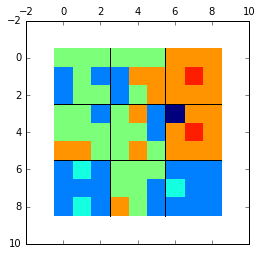

In [12]:
import sys
sys.path.append('../')

import tictactics_cython as tact
from tictactics_cython import Board
import matplotlib
import numpy as np
import cProfile
from matplotlib import pyplot as plt
import time
%matplotlib inline

board = np.zeros((9,9))
for x in [(1,4),(0,8),(2,6),(5,4),(4,6),(4,8),(6,6),(8,8)]:
    board[x]=1
for o in [(1,0),(2,0),(1,8),(2,8),(3,5),(6,0),(7,7),(8,7)]:
    board[o]=-1
big_board = np.array([[0,0,0],
                      [0,0,0],
                      [0,0,0]])

player = 1
game = Board(board=board,big_board = big_board,player = player)
for move in [(3,4),(2,3),(7,0),(3,2),(0,7),(1,3),(5,1),(7,5),(3,8),(1,6),(5,0),(7,2),(5,8),(6,7),(1,5),
             (5,7),(8,3),(8,2),(7,8),(3,7),(2,5),(6,8),(0,6),(1,2),(5,6),(6,2),(2,7),(8,5),(8,6),(8,0),
             (7,1),(4,5)]:
    game.update_move(move)
log_len = len(game.log)
init()

tact.fancy_board(game)
t0 = time.clock()
# cProfile.run('node,tree = dfpn.solve(game,root = True,epsilon=1.1)',sort = 'tottime')
node ,tree= solve(game,3,{1:0,0:1,-1:2,2:1,-2:1},1,root = True,epsilon=1.02)
print 'time',time.clock() - t0

print tree

In [10]:
tree

''